# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 23

**Author 1 (sciper):** Jérémy Baffou (301972)  
**Author 2 (sciper):** Léon Delachaux (296093)   
**Author 3 (sciper):** Martin Dahl (344218)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

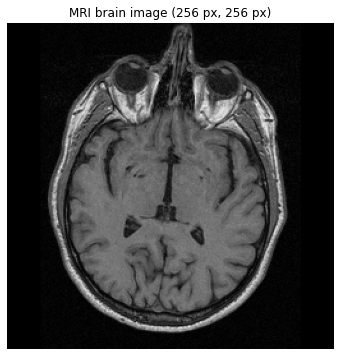

In [2]:
import skimage.io
from skimage import restoration
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.1bis Image Preprocessing

Before diving into the segmentation of our brain image, it is always good practice to do some prepocessing. In the prepocessing we can try to remove noise using non-linear filters such as median filtering, wiener filter or non local mean filtering. We can also enhance the edges of the image using for example sobel filter. 

Another interesting aspect of the image is its histogram. Sometimes if we are interested in region with similar pixel values, it can be useful to do a histogram equalization to try to make clearer distinction between these regions.

#### Helpers

In [3]:
import cv2

MAX_PIXEL_VALUE = 255

def median_filter(img,k=3):
    new_image = np.zeros(img.shape,dtype=np.uint8)
    offset = int((k-1)/2)
    for i in range(offset,img.shape[0]-offset):
        for j in range(offset,img.shape[1]-offset):
            new_image[i,j] = int(np.median(img[i-offset:i+offset+1,j-offset:j+offset+1]))
    return new_image

def sobel_filter(img,balance=0.2):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    final = cv2.addWeighted(grad, balance, img, 1-balance, 0)
    return final

def plot_images(img_1,img_2,title_1,title_2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(img_1, cmap='gray')
    ax[0].set_title(title_1+'({} px, {} px)'.format(img_1.shape[0], img_1.shape[1]))
    ax[0].axis('off')
    ax[1].imshow(img_2, cmap='gray')
    ax[1].set_title(title_2+'({} px, {} px)'.format(img_2.shape[0], img_2.shape[1]))
    ax[1].axis('off')
    plt.show()

#### Histogram Equalization

We will perform histogram equalization to see if we can have a clearer separation (in term of pixel values) between our object of interest, the brain tissues, and the bones. 

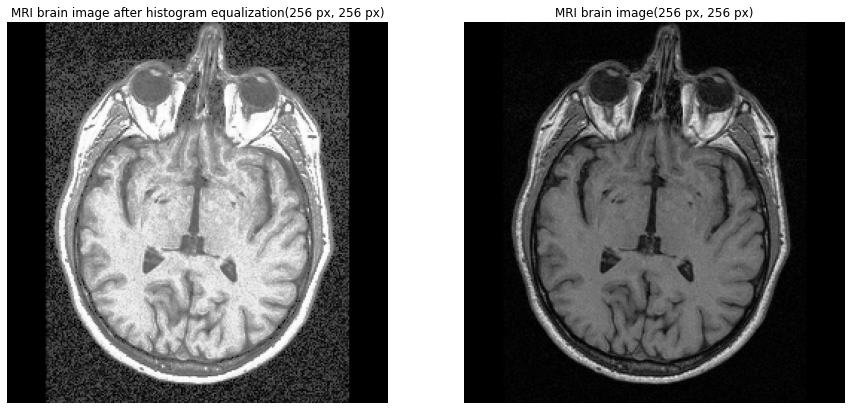

In [4]:
equalized_brain = cv2.equalizeHist(brain_im)
plot_images(equalized_brain,brain_im,"MRI brain image after histogram equalization","MRI brain image")

We can see that the histogram equalization was not really helpful to do the distinction brain/bone, but it allowed us to better see the noise in our image. First of all the noise is not uniformly spreaded in our image, we see that left and right borders are spared by the noise. We will crop the image in order to keep only a picture with some uniform noise in it.

In [5]:
brain_im = brain_im[:,30:-30] # Crop the black borders without noise

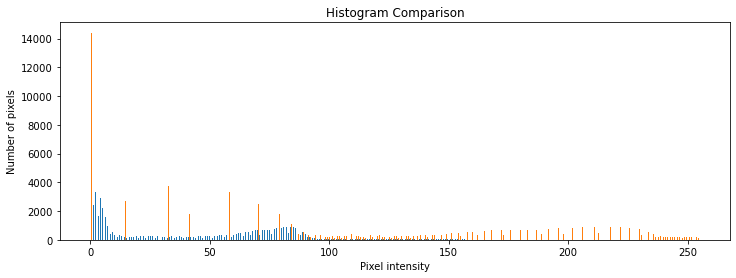

In [6]:
nb_bins = 256
# Display histogram
fig, ax = plt.subplots( figsize=(12, 4))
ax.hist([brain_im.ravel(),equalized_brain.ravel()], bins=nb_bins)
ax.set_title("Histogram Comparison")
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.show()

We can see the effect of the histogram equalization, we have a wider diversity of pixels, especially in the high values.

#### Noise removal

There exists several techniques to remove the noise. We tried three of them : 
- Median filtering
- Wiener filtering
- Non-local Means Denoising 

The **Median filter** works by replacing the value of a pixel by the median of its neighbours:

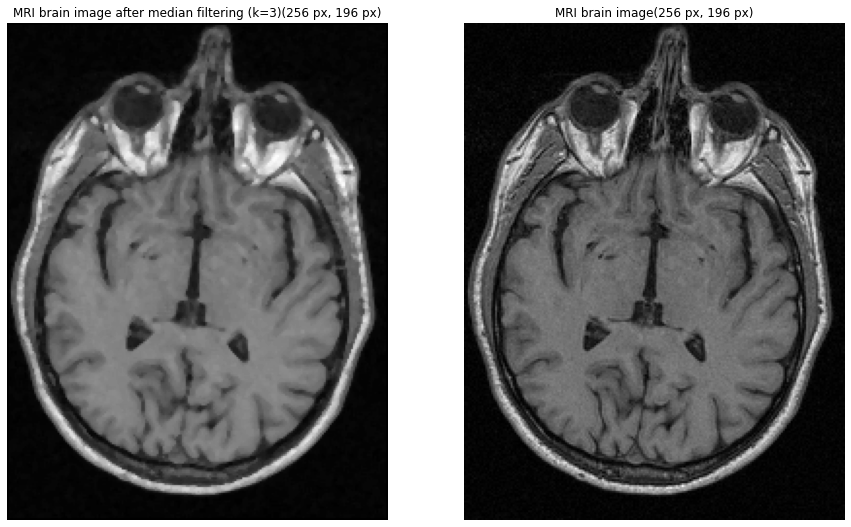

In [7]:
plot_images(median_filter(brain_im,k=3),brain_im,"MRI brain image after median filtering (k=3)","MRI brain image")

We can see that the filter has smoothed the image, which can be good in certain cases but also problematic in edge detection for example. Indeed we can see that the junction between the brain and the bone in the upper part of the image becomes really blury, which can be hard to segment afterward.

**Wiener Filter**

The idea behing the wiener filter is to reduce the frequency where the power of the noise is greater than the power of the image signal and to remove any effect of a system on the image. Here we assumed that the image was subject to no system but only to a noise. In the wiener filter we need to specify the location of the noise, which is done by taking the 4 (noisy) corner of the image and concatening them. We do this to increase the range of values for the noise, and thus to get a better estimate of its power. But this method is suboptimal as by concatenating, we add some non linearity to our noise, artificially. In an ideal world, there would be a big portion of the image with only noise, but it is hard to find in such a small image.

In [8]:
concat_noise_up = np.concatenate([brain_im[:25,:25],brain_im[:25,-25:]],axis=1)
concat_noise_down = np.concatenate([brain_im[-25:,:25],brain_im[-25:,-25:]],axis=1)
concat_noise = np.concatenate([concat_noise_up,concat_noise_down],axis=0)

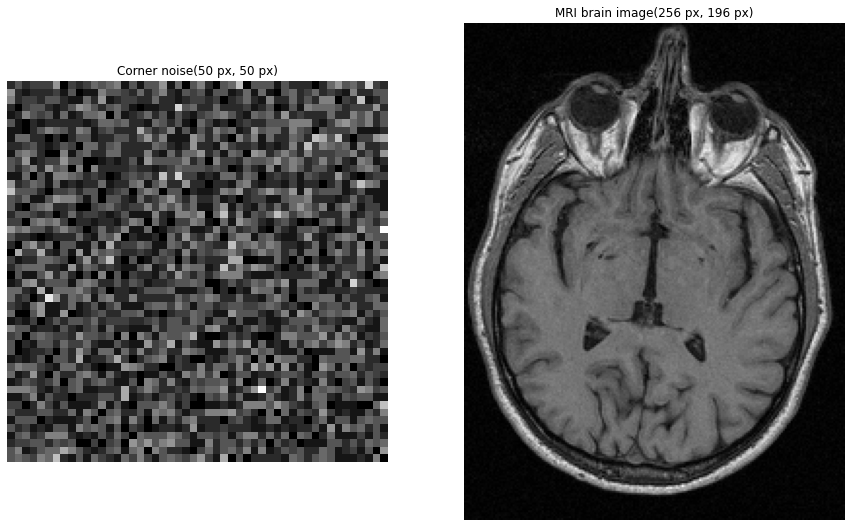

In [9]:
plot_images(concat_noise,brain_im,"Corner noise","MRI brain image")

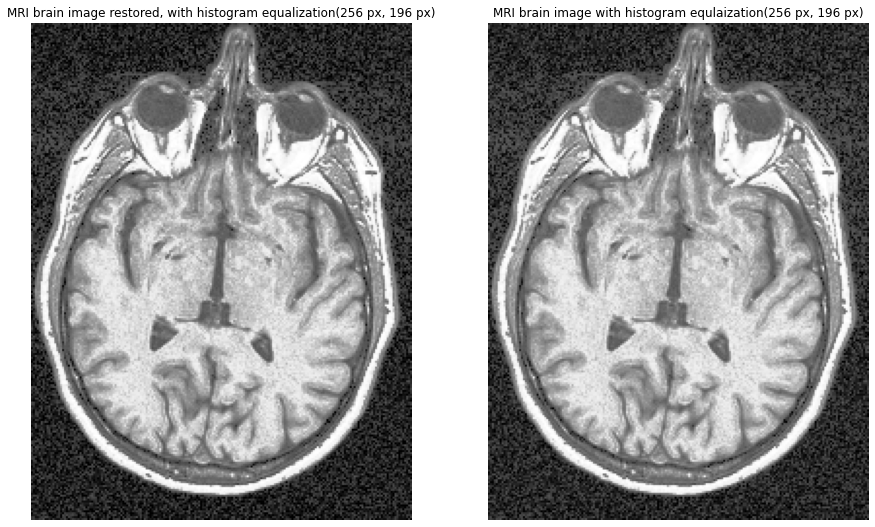

In [10]:
# https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/VELDHUIZEN/node15.html
# Wiener Filter
from scipy.signal import convolve2d as conv2
import scipy.fft
# Unaffected image
im = brain_im

# PSF filter
h_PSF = np.ones((1, 1))
#h_PSF = np.ones(1)
H_PSF = scipy.fft.fft2(h_PSF, s=im.shape)

im = conv2(im, h_PSF, 'same')
noise = concat_noise

# Spectras for autocorr
im_autocorr = scipy.signal.correlate2d(im, im,"same")
noise_autocorr = scipy.signal.correlate2d(noise, noise, "same")
im_autocorr_fft = scipy.fft.fft2(im_autocorr)
noise_autocorr_fft = scipy.fft.fft2(noise_autocorr, s=im.shape)
# Assembling wiener filter
H_wiener = np.conjugate(H_PSF)/(np.power(np.abs(H_PSF),2) + (noise_autocorr_fft/im_autocorr_fft))

# Restoring using wiener filter
im_fft = scipy.fft.fft2(im)
im_restored_fft = im_fft*H_wiener
im_restored = np.abs(scipy.fft.ifft2(im_restored_fft))
im_restored = im_restored.astype(np.uint8)

# Plot
plot_images(cv2.equalizeHist(im_restored),
                        cv2.equalizeHist(brain_im),"MRI brain image restored, with histogram equalization",
                        "MRI brain image with histogram equlaization")

We can see that we successfully removed some noise on the corner (the density of the noise is slightly less strong). But the result is not outstanding.

**Non Local Mean Denoising**

Non Local Mean Denoising is based on the assumption that the noise has zero mean. Thus if you take a small region in your image, by searching for other similar small region and doing their averages, you should get rid of the noise. This is implemented in OpenCV, and we use it based on the recommendation of: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html. 

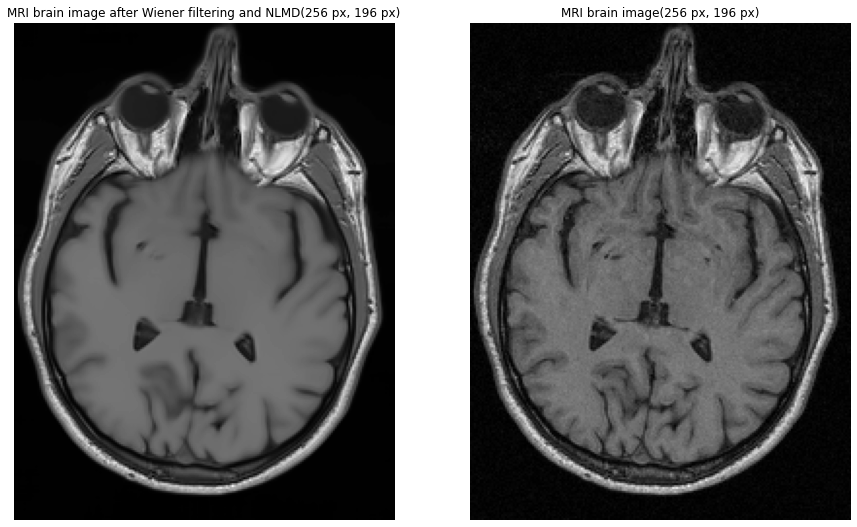

In [11]:
smooth = cv2.fastNlMeansDenoising(im_restored,h=10,templateWindowSize=7,searchWindowSize=21)
plot_images(smooth, brain_im, "MRI brain image after Wiener filtering and NLMD","MRI brain image")

The result of the Non Local Mean Denoising is interesting because it has removed the small subtilities in the brain tissues, wich is good for our purpose of estimating its area. It can be problematic if we look for specific detail, but here it has more advantages for us.

#### Edge Enhancement

We can enhance the edges of an image by adding a small amount of the derivative of the image into it. We have to be careful when doing this because we can also increase the power of the noise. We used a sobel filter to compute the derivative of the image.

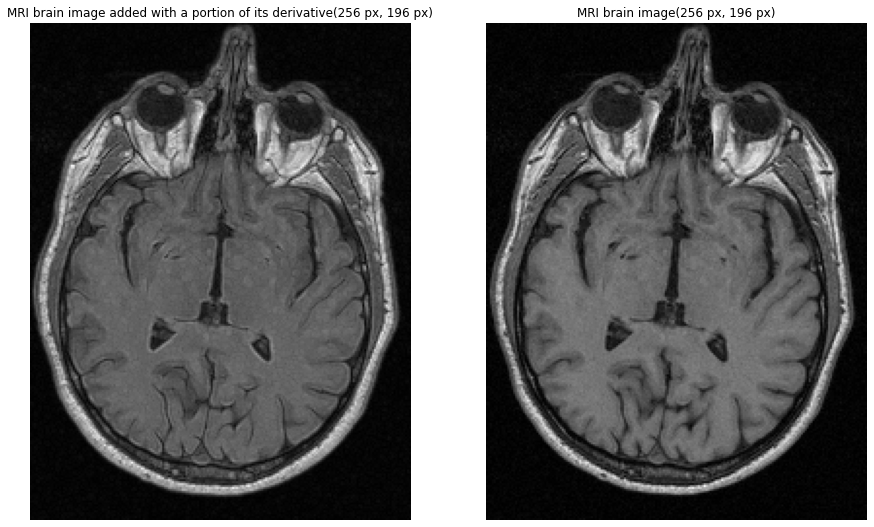

In [12]:
plot_images(sobel_filter(brain_im),brain_im,"MRI brain image added with a portion of its derivative","MRI brain image")

#### Additionnal notes

##### Parameters
There are many parameters in our algorithms, in the preprocessing step or in the segmentation. All these parameters are either tuned empirically or by following gold standard guidelines. This is a bit problematic as if you change a single parameter, all your downstream analysis is impacted, which is suboptimal. But it seems to be a classic trait of image processing, if you want to have good result you have to tailor the method to your image.

##### Area
To estimate the area, we used the mask of the segmentation (where all pixel predicted to belong to the object of interest are set to 255, and the rest to 0). We first sum the values of all pixels and then divide by 255 (the pixel value for object belonging). It gives a weight at each predicted pixel 1. A interesting approach would be to average the area for a given method by iterating over different hyper parameter but we did not have the time to do it.

### 1.2 Region growing (5pts)

Region growing is a recursive segmentation method. You start from a seed (initial x,y coordinates) and then iteratively add to your object segmentation, all the neighbouring pixels that matches a certain threshold. Then you apply the function recursively on the valid neighbours. The user must specify the seed and the threshold. We give two implementation, one based on recursivity (rec_grow) and the other is iterative (iterative_grow). Python is not a functional language, thus it is not optimized for recursivity. This is why we prefer using the second implementation which is more "pythonic".

In [13]:
# Add your implementation and discussion
def rec_grow(img,x,y,l,tr):
    if img[x,y] > tr and (x,y) not in l:
        l.append((x,y))
        for p in neighbours(img,x,y):
            rec_grow(img,p[0],p[1],l,tr)
        
def neighbours(img,x,y):
    neighbours = []
    for i in range(-1,2):
        for j in range(-1,2):
            if not (i==0 and j==0):
                if in_image(img,x+i,y+j):
                    neighbours.append((x+i,y+j))
    return neighbours

def in_image(img,x,y):
    return x >= 0 and y >= 0 and x < img.shape[0] and y < img.shape[1]

def iterative_grow(img,x,y,tr):
    candidate = []
    region = []
    visited = set()
    candidate.append((x,y))
    if not in_image(img,x,y):
        raise Exception("The seed given is not in the image boundaries.")
    while len(candidate) > 0:
        c = candidate[-1]
        x_c, y_c = c
        if img[x_c,y_c] > tr and (x_c,y_c) not in visited:
            visited = visited.union(set([tuple((x_c,y_c))]))
            region.append(c)
            candidate.pop()
            for new_c in neighbours(img,x_c,y_c):
                candidate.append(new_c)
        else:
            candidate.pop()
    return region

We give two different segmentation, one based on the smooth image and the other on only the post wiener filter one (im_reconstructed). The idea between smoothing/noise reduction is to have a more uniform image where the threshold will produce less false negative. The segmentation based on smooth is indeed more smooth, where as the second one is more precise. We will use the second one, with a bit of morphological closing on it to remove the very small hole, to estimate the area. The closing step can be discussed as we also remove holes that are true holes, but in order to have the most homogeneous segmentation we decided to keep it. 

In all our different segmentation, we will only use the smoothed version if we do not loose too much information compared to the post wiener version, and if it gives us a nicer segmentation. 

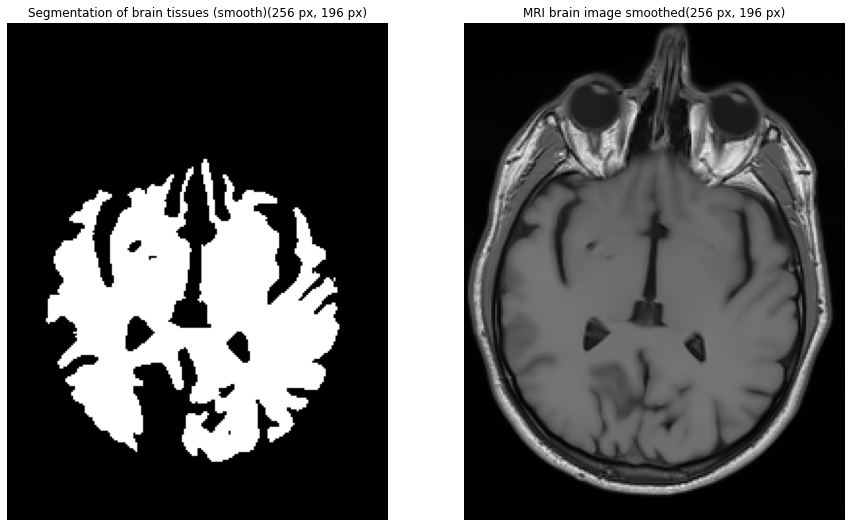

In [14]:
# Region growing on smooth image
brain_segmentation = np.zeros(smooth.shape,dtype=np.uint8)
for i in iterative_grow(smooth,100,75,69):
    brain_segmentation[i[0],i[1]] = 255
plot_images(brain_segmentation,smooth,"Segmentation of brain tissues (smooth)","MRI brain image smoothed")

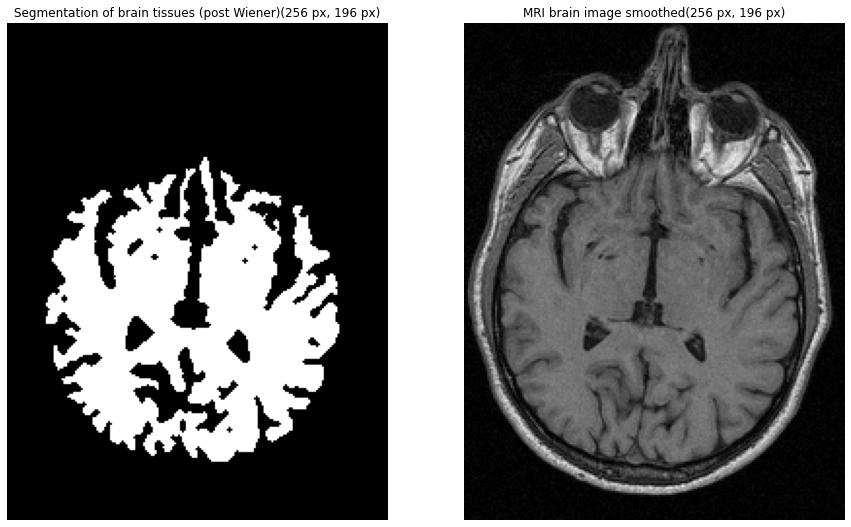

The area in pixel of the brain in the image is 13006 pixels


In [15]:
# Region Growing (seed = (00,80) and threshold = 68)
brain_segmentation = np.zeros(smooth.shape,dtype=np.uint8)
for i in iterative_grow(median_filter(im_restored),100,80,68):
    brain_segmentation[i[0],i[1]] = MAX_PIXEL_VALUE
# Morphological closing to remove artificial small holes
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) 
brain_segmentation_closed = cv2.morphologyEx(brain_segmentation, cv2.MORPH_CLOSE, kernel)
plot_images(brain_segmentation_closed,im_restored,"Segmentation of brain tissues (post Wiener)","MRI brain image smoothed")
area = brain_segmentation_closed.sum()/MAX_PIXEL_VALUE
print(f"The area in pixel of the brain in the image is {int(area)} pixels")

### 1.3 Contour detection (5pts)

Another currently used method in image segmentation is contour detection. Indeed, we can describe an object by its contour, thus if we find the contour of our brain tissue we would be able to compute its area! To detect the contours, various methods exist but we decided to implement a Laplacian of Gaussian (LoG) method. The idea is that by first applying a gaussian smoothing and then computing the zero-crossing of the second derivative of the image, we will be able to detect its edges. We used the method in OpenCV to perform the gaussian filtering and to compute the laplacian. We wrote a function to compute the zero crossing of our LoG. In theory, a zero crossing is a pixel whose value is zero and that has in its neighbours at least a positive pixel and a negative pixel. The problem is that our image is still noisy and that the laplacian of gaussian does not give us perfect result. Thus we have added an extra constraint, the max local difference between neighbouring pixel should be greater than a threshold. This means that we are only looking for strong edges. The tuning of parameter is done experimentally, thus it is not a perfect setup. But as in many of the method in image processing, the interaction between the user and the algorithm is key. 

In the process we apply some morphological operation to either fill holes or to remove segmentation artifact.

The idea to compute the area from the edges is to do a region growing inside the object and have as stop condition that if the pixel is an edge we stop the growing in this direction. To do so we use our region growing implementation and invert the image (multiply it by -1), and set a negative threshold. Thus we capture only pixel whose values are 0.

To have a better edge segmentation we also use a sobel filter to enhance the edges of our image (see the pre-processing section for more detail).

In [16]:
#HELPERS

def LoG(img,sigma=1,tr=150):
    gaussian = cv2.GaussianBlur(img,(0,0),sigma)
    log = cv2.Laplacian(gaussian, cv2.CV_64F)
    edge_mask = zero_crossing(log,tr)
    return edge_mask

def zero_crossing(img,tr=0):
    zero_crossing = np.zeros(img.shape,dtype=np.float32)
    max_diff = np.abs(img.max() - img.min())
    for i in range(1,img.shape[0]):
        for j in range(1,img.shape[1]):
            local_window = img[i-1:i+2,j-1:j+2]
            local_min = local_window.min()
            local_max = local_window.max()
            if local_min < 0 and local_max > 0 and (local_max - local_min) > tr:
                zero_crossing[i,j] = 1
    return zero_crossing

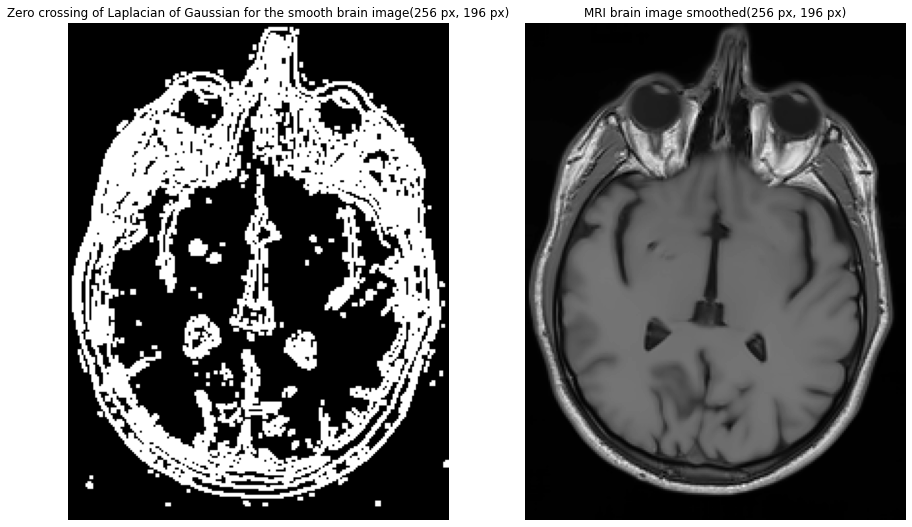

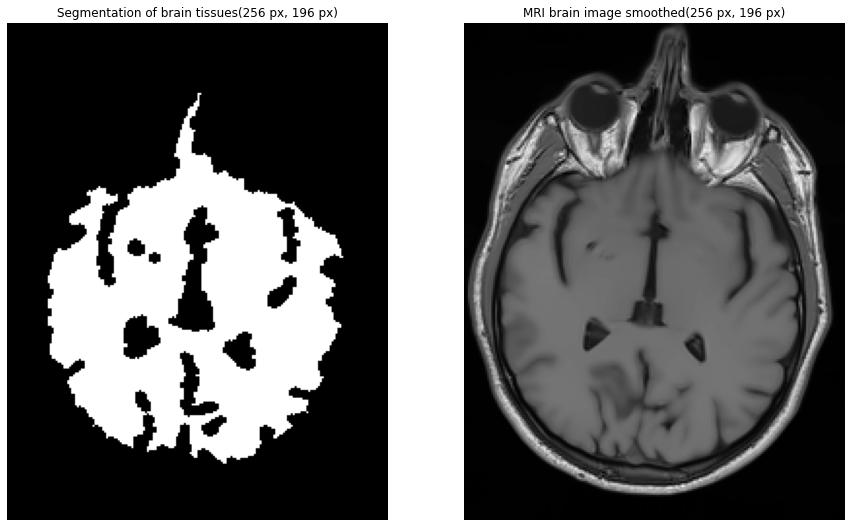

The area in pixel of the brain in the image is 14808 pixels


In [17]:
# Compute the Laplacian of Gaussian
smooth_log = LoG(sobel_filter(smooth),sigma=0.9,tr=5)
# Remove artifacts
kernel = np.ones((2,2))
smooth_log = cv2.morphologyEx(smooth_log, cv2.MORPH_OPEN, kernel)
plot_images(smooth_log,smooth,"Zero crossing of Laplacian of Gaussian for the smooth brain image","MRI brain image smoothed")
# Compute area inside the contours
brain_segmentation_edge = np.zeros(smooth.shape,dtype=np.uint8)
for i in iterative_grow(-smooth_log,100,80,-1):
    brain_segmentation_edge[i[0],i[1]] = MAX_PIXEL_VALUE
# Close holes
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) 
brain_segmentation_edge_closed = cv2.morphologyEx(brain_segmentation_edge, cv2.MORPH_CLOSE, kernel)
plot_images(brain_segmentation_edge_closed,smooth,"Segmentation of brain tissues","MRI brain image smoothed")
area = brain_segmentation_edge_closed.sum()/MAX_PIXEL_VALUE
print(f"The area in pixel of the brain in the image is {int(area)} pixels")

We can see that the segmentation is less precise than with region growing. This is due to the difficulty to detect the edges in the smooth image. We can see an oversegmented section in the upper part of the image which is due to the difficulty to distinguish the difference between tissues and bones in this area. Here we likely have an overestimation of the area. 

We thus try to segment the post wiener image rather than the smooth one. In theory it would be necessarly a better segmentation as by smoothing we remove some edge (at least they are less pronounced). But as we have noise, we should be careful that it does not impact too much our segmentation.

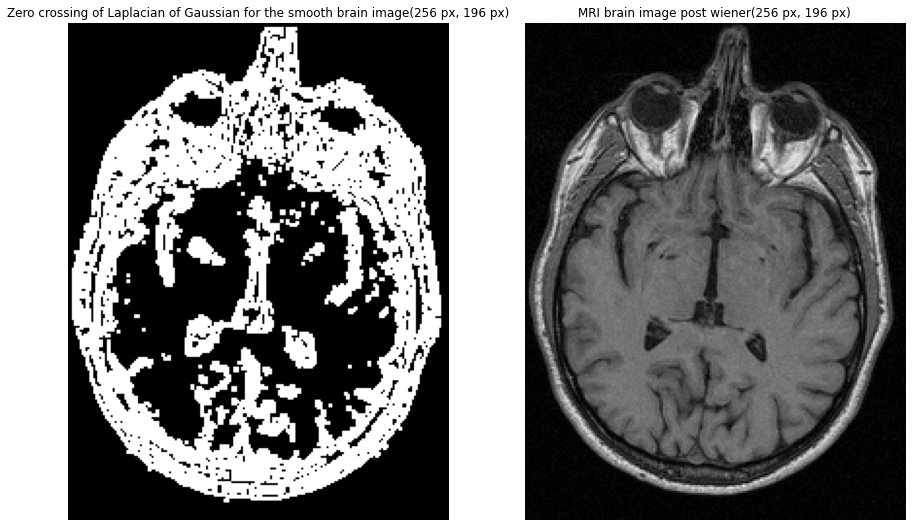

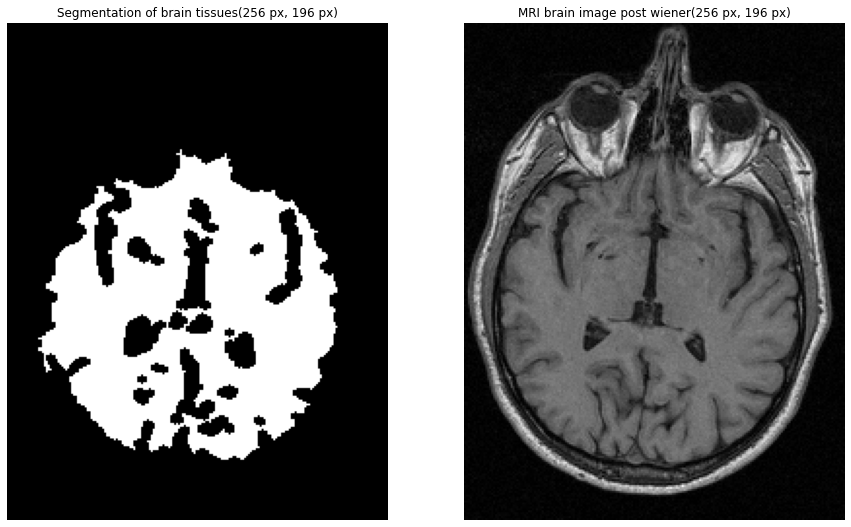

The area in pixel of the brain in the image is 13942 pixels


In [18]:
# Compute the Laplacian of Gaussian
wiener_log = LoG(sobel_filter(im_restored,balance=0.5),sigma=0.9,tr=14)
# Remove artifacts
kernel = np.ones((2,2))
wiener_log = cv2.morphologyEx(wiener_log, cv2.MORPH_OPEN, kernel)
plot_images(wiener_log,im_restored,"Zero crossing of Laplacian of Gaussian for the smooth brain image","MRI brain image post wiener")
# Compute area inside the contours
brain_segmentation_edge = np.zeros(smooth.shape,dtype=np.uint8)
for i in iterative_grow(-wiener_log,100,90,-1):
    brain_segmentation_edge[i[0],i[1]] = MAX_PIXEL_VALUE
# Close holes
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) 
brain_segmentation_edge_closed = cv2.morphologyEx(brain_segmentation_edge, cv2.MORPH_CLOSE, kernel)
plot_images(brain_segmentation_edge_closed,im_restored,"Segmentation of brain tissues","MRI brain image post wiener")
area = brain_segmentation_edge_closed.sum()/MAX_PIXEL_VALUE
print(f"The area in pixel of the brain in the image is {int(area)} pixels")

We can see that the segmentation is a bit better as we don't have the upper non-tissue part as with the smooth image. Nevertheless the details are pretty poor due to the smoothing and the morphological operation needed to close holes or remove the segmentation artifacts along the way. There may be a possibility to better tune the model with the variance of the gaussian blur and the threshold for zero crossing, but this is the best we found. 

### 1.4 Additional method (5pts)

As an additionnal method we decided to use k-means. Indeed k-means can be used to compress an image by aggregating pixel to some cluster with given values. In the idea it is similar to region growing, you want to aggregate all pixels which are similar. We use an implemenatation of k-means that we have used in a preceding course at EPFL: Machine Learning (CS-433). We decided to run the algorithm on the smooth version as it gave a nicer segmentation with less holes. Thus we oversegment a bit (so overestimation of the area), but it gives a really nice object segmentation without losing too much information.

In [19]:
# HELPERS
def initialize_clusters(data, k):
    """randomly initialize the k cluster centers (the means). Make sure you choose k clusters from the data itself,
             or ensure otherwise that your initializations have the same scale as the data
    
    Args:
        data: shape = (N, d). original data. 
        k: integer number. predefined number of clusters for the k-means algorithm. 
    Returns:
        numpy array with shape (k, d) which corresponds to the k initial clusters.
    """
    N, _ = data.shape
    return data[np.random.choice(N, k)]

def build_distance_matrix(data, mu):
    """builds a distance matrix.
    
    Args:
        data: numpy array of shape = (N, d). original data. 
        mu:   numpy array of shape = (k, d). Each row corresponds to a cluster center.
    Returns:
        squared distances matrix,  numpy array of shape (N, k):
            row number i column j corresponds to the squared distance of datapoint i with cluster center j.
    """
    N, _ = data.shape
    k, _ = mu.shape
    distance_matrix = np.zeros((N, k))
    for j in range(k):
        distance_matrix[:, j] = np.sum(np.square(data - mu[j, :]), axis=1)
    return distance_matrix


def update_kmeans_parameters(data, mu_old):
    """compute one step of the kmeans algorithm: using mu_old, find to which cluster each datapoint belongs to, 
            then update the parameter cluster centers.
    
    Args:
        data:   numpy array of shape = (N, d). original data. 
        mu_old: numpy array of shape = (k, d). Each row corresponds to a cluster center.
    Returns:
        losses: shape (N, ), contains the (old) squared distances of each data point to its (old) cluster mean (computed from mu_old).
        assignments: vector of shape (N, ) which contains the cluster associated to each data point.
        mu: updated vector mu of shape (k, d) where each row corresponds to the new cluster center.
    """
    _, d = data.shape
    k, _ = mu_old.shape
    distance_matrix = build_distance_matrix(data, mu_old)
    losses = np.min(distance_matrix, axis=1)
    assignments = np.argmin(distance_matrix, axis=1)

    # update the mu
    mu = np.zeros((k, d))
    for j in range(k):
        rows = np.where(assignments == j)[0]
        mu[j, :] = np.mean(data[rows, :], axis=0)
    return losses, assignments, np.nan_to_num(mu)


def preprocess_image(original_image,dim=1):
    """preprocess the image. 
    vectorize the three matrices (each matrix corresponds to a RGB color channel). **don't normalize!** 
    
    Args: 
        original_image: numpy array of shape (480, 480, 3) 
    Returns:
        processed_image: numpy array of shape (480*480, 3)
    """
    processed_image = original_image.reshape(
        (original_image.shape[0] * original_image.shape[1], dim))
    processed_image = processed_image.astype(float)
    print(
        "Current image: the shape of image={s}, the data type={dt}.".format(
            s=processed_image.shape, dt=processed_image.dtype))
    return processed_image

def kmean_compression(original_image, k=3, max_iters=100, threshold=1e-7):
    """using k-means for image compression.
    Args: 
        original_image: numpy array of shape (480, 480, 3).
        processed_image: numpy array of shape (480*480, 3).
        k: scalar. Number of clusters.
        max_iters: integer. Max number of iterations for the kmeans algorithm.
        threshold: scalar. Stop the kmeans algorithm if the loss decrease between two iterations
                        is lower than the threshold.
    """
    
    processed_image = preprocess_image(original_image)
    mu_old = initialize_clusters(processed_image, k)
    
    # init some empty lists to store the result.
    loss_list = []
    
    # start the kmeans
    for iter in range(max_iters):
        losses, assignments, mu = update_kmeans_parameters(processed_image, mu_old)
        
        # calculate the average loss over all points
        average_loss = np.mean(losses)
        loss_list.append(average_loss)

        if iter % 10 == 0:
            print(
                "The current iteration of kmeans is: {i}, the average loss is {l}.".format(
                    i=iter, l=average_loss))
        
        # check converge
        if iter > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break

        # update mu
        mu_old = mu

    image_reconstruct = mu[assignments].reshape(original_image.shape).astype(np.uint8)
    return image_reconstruct

def aggregate(img,x,y,color):
    candidate = []
    region = []
    visited = set()
    candidate.append((x,y))
    if not in_image(img,x,y):
        raise Exception("The seed given is not in the image boundaries.")
    while len(candidate) > 0:
        c = candidate[-1]
        x_c, y_c = c
        if img[x_c,y_c] == color and (x_c,y_c) not in visited:
            visited = visited.union(set([tuple((x_c,y_c))]))
            region.append(c)
            candidate.pop()
            for new_c in neighbours(img,x_c,y_c):
                candidate.append(new_c)
        else:
            candidate.pop()
    return region

In [20]:
# Compute the compressed image version (relaunch the cell if you have a division by zero error)
compressed_brain_im = kmean_compression(smooth,k=4)

Current image: the shape of image=(50176, 1), the data type=float64.
The current iteration of kmeans is: 0, the average loss is 260.29555963010205.
The current iteration of kmeans is: 10, the average loss is 75.54854858961548.


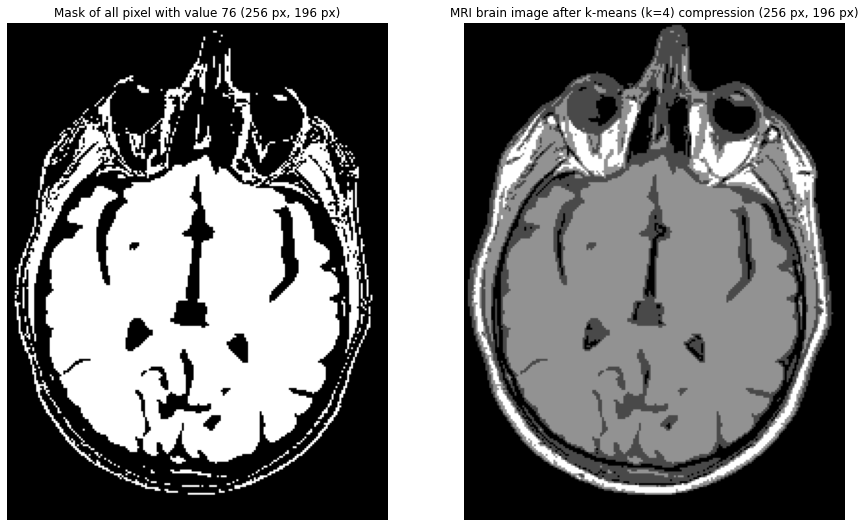

In [21]:
mask = compressed_brain_im == 76
plot_images(mask, compressed_brain_im, "Mask of all pixel with value 76 ", "MRI brain image after k-means (k=4) compression ")

Once we have computed the compression, we want to keep only the pixels of tissues. Unfortunately, the pixel value is also assigned for some bones. Thus we cannot simply count the number of pixel with the given value (after empirical search, here the value is 76. But it can change depending on pre-processing). We decided to run a adjusted version of region growing inside the mask to capture only the inner part (i.e. the brain tissues). But before we first applied a morphological opening to break the link(s) between the brain and the bones in the mask.

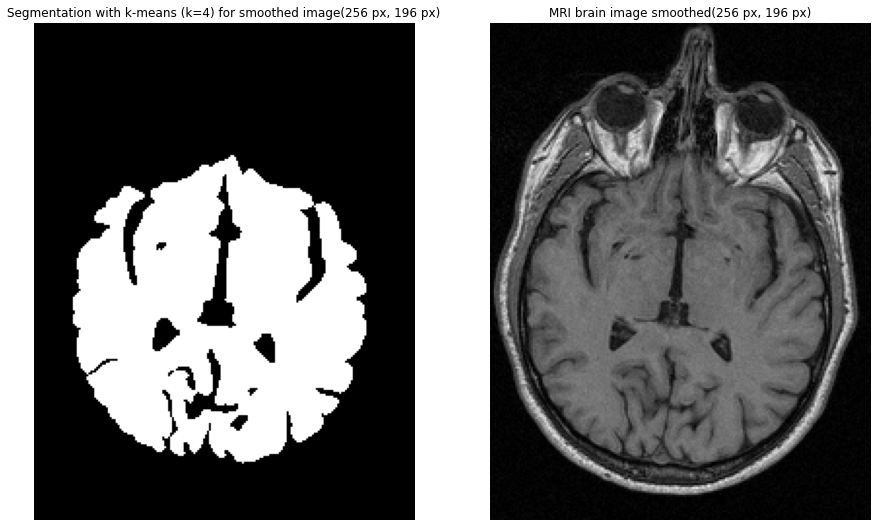

The area in pixel of the brain in the image is 16052 pixels


In [22]:
# Break the links between brain and bones
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) 
mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
# Aggregate pixel for brain tissues
brain_segmentation_k_means = np.zeros(mask.shape,dtype=np.uint8)
for i in aggregate(mask,125,75,1):
    brain_segmentation_k_means[i[0],i[1]] = 255
plot_images(brain_segmentation_k_means,im_restored,"Segmentation with k-means (k=4) for smoothed image","MRI brain image smoothed")
area = brain_segmentation_k_means.sum()/MAX_PIXEL_VALUE
print(f"The area in pixel of the brain in the image is {int(area)} pixels")

This segmentation is really nice, it is a bit less precised than the one with region growing. We do not see all the little folding in the brain tissues. Thus the segmentation to choose would depend on its use. For our purpoes of computing the area, a smooth version seems to be okay as segmenting the little folding can lead to a noisy segmentation. But if in your downstream analysis you need to study these details, the region growing approach is prefered.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [23]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


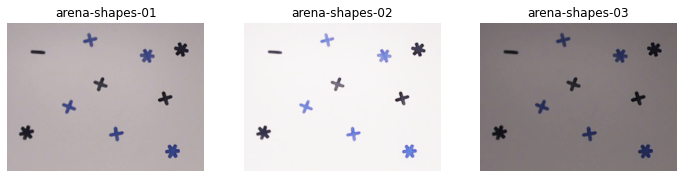

In [24]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

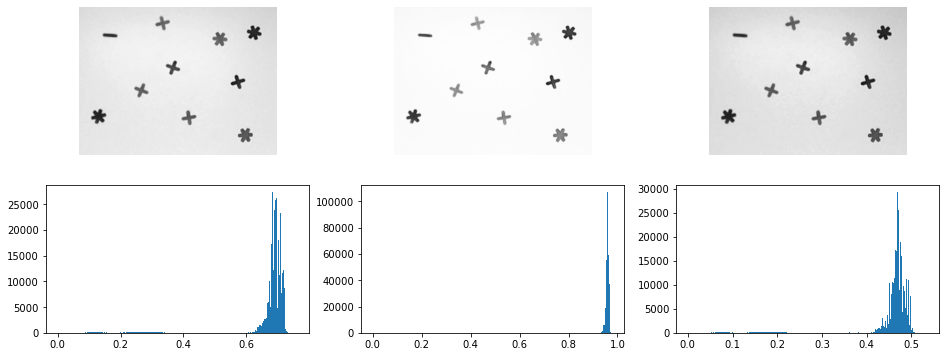

In [25]:
import cv2
from skimage.color import rgb2gray

v_images = np.empty(images.shape[0:3])
fig, axes = plt.subplots(2, 3, figsize=(16,6))
for i, img in enumerate(images):
    v_images[i, :, :] = rgb2gray(img)
    plt.subplot(2, 3, i+1)
    plt.imshow(v_images[i],cmap = 'gray') # in intensity
    plt.axis('off')
    plt.subplot(2,3,i+4)
    plt.hist(v_images[i].flatten(), bins=256)
plt.show()

We can see that the resulting images are the same as before but in grayscale. The histograms shows the distribution of the values of the pixels. We can observe there is a high peak that corresponds to the background pixels. In order to treat the three images the same way, we need to do make these histograms equivalent, and that is why we are using histogram equalization.


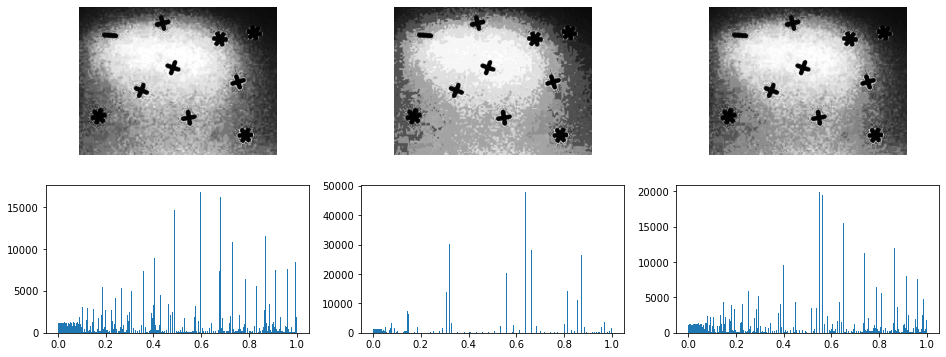

In [26]:
import cv2
# from cv2 import equalizeHist
import numpy as np

from skimage import exposure

eq_images = np.empty(v_images.shape)

fig, axes = plt.subplots(2, 3, figsize=(16,6))
for i, img in enumerate(v_images):
    # eq_images[i, :, :] = cv2.equalizeHist(v_images[i])  # does not work
    eq_images[i, :, :] = exposure.equalize_hist(img)
    plt.subplot(2, 3, i+1)
    plt.imshow(eq_images[i], cmap = 'gray') # in intensity
    plt.axis('off')
    plt.subplot(2,3,i+4)
    plt.hist(eq_images[i].flatten(), bins=256)
plt.show()

After this, we have to choose a threshold to identify the shapes from the background. After some trials, we chose a threshold value of 0.03. If the value of a pixel is above this threshold, it is supposed to belong to the background.

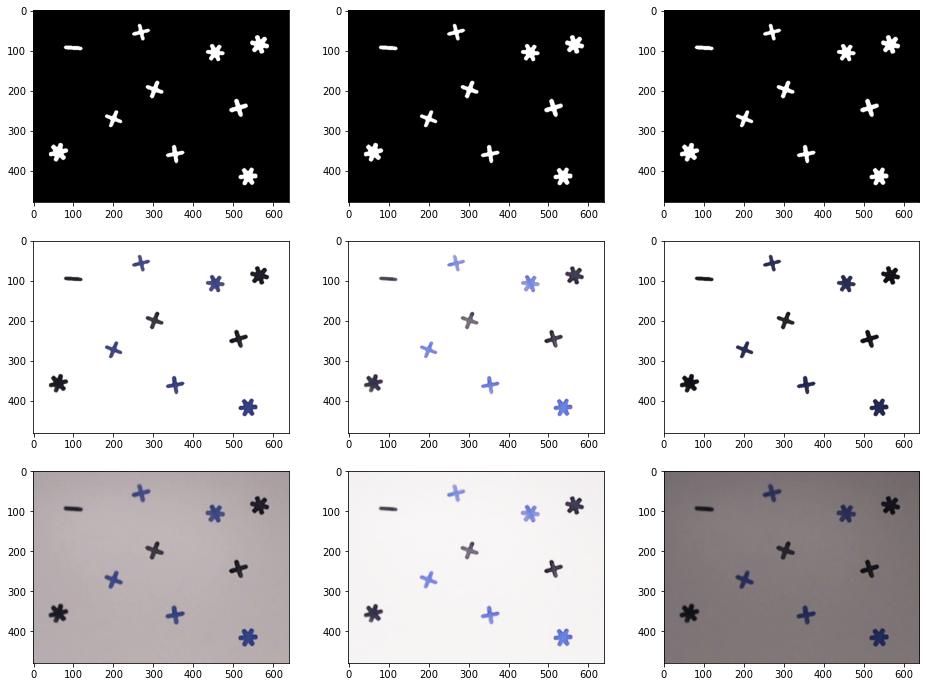

In [27]:
masks = np.empty(eq_images.shape)
no_background = images.copy()
fig, axes = plt.subplots(3, 3, figsize=(16,12))
for i, img in enumerate(eq_images):
    masks[i, :, :] = cv2.threshold(img, 0.03, 1, cv2.THRESH_BINARY_INV)[1]
    plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap = 'gray')
    
    no_background[i][(masks[i]==0)] = 255
    plt.subplot(3, 3, i+4)
    plt.imshow(no_background[i])
    
    plt.subplot(3, 3, i+7)
    plt.imshow(images[i])
plt.show()

We can see that the mask allows us to treat either only the background or only the shapes. We plot the original images to check that the area covered by the shapes remains the same as we need to compute it for the second task.

Now we can create a gaussian mixture model for each image in order to cluster the pixels depending on their colors, so that we will be able to distinguish the blue shapes from the dark ones.


In [28]:
from sklearn import mixture

g1 = mixture.GaussianMixture(n_components=2).fit((eq_images[0][(masks[0]==1)]).reshape(-1,1))
g2 = mixture.GaussianMixture(n_components=2).fit((eq_images[1][(masks[1]==1)]).reshape(-1,1))
g3 = mixture.GaussianMixture(n_components=2).fit((eq_images[2][(masks[2]==1)]).reshape(-1,1))

g = [g1, g2, g3]

Here, we create a function that returns the eight neighbours of one pixel. We need it for the next function to perform the region growing for one shape. (We could have used our previous implementation of region growing but like this we have another version in our toolbox)


In [29]:
def get8n(x, y, shape):
    out = []
    if x-1 >= 0 and y-1 >= 0:
        out.append((x-1, y-1) )
    if x-1 >= 0 :
        out.append((x-1, y))
    if x-1 >= 0 and y+1 < shape[1]:
        out.append((x-1, y+1))
    if y-1 >= 0:
        out.append((x, y-1))
    if y+1 < shape[1]:
        out.append((x, y+1))
    if x+1 < shape[0] and y-1 >= 0:
        out.append((x+1, y-1))
    if x+1 < shape[0] :
        out.append((x+1, y))
    if x+1 < shape[0] and y+1 < shape[1]:
        out.append((x+1, y+1))
    return out

def region_growing(img, seed):
    liste = []
    outimg = np.zeros_like(img)

    liste.append((seed[0], seed[1]))
    while(len(liste) > 0):
        pix = liste[0]
        outimg[pix[0], pix[1]] = 1
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] > 0 and outimg[coord[0], coord[1]] == 0:
                outimg[coord[0], coord[1]] = 1
                liste.append((coord[0], coord[1]))
        liste.pop(0)
    return outimg

The next function can count the shapes of each color and also return the area that they cover. The function works in an iterative manner. We begin with upper left corner, then we go from left to right and top to bottom. Each time that we encounters a shape, we perform region growing into it, compute its area and then remove it from the image. Then we keep going with our walk in the image. The color prediction is done using the GMM trained before.

In [30]:
def count_shapes(image, mask, g):
    count = 0
    count1 = 0
    surface1 = 0
    surface2 = 0
    count2 = 0
    temp = mask.copy()
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if temp[i, j] == 1:
                # print((i, j))
                # fig, ax = plt.subplots()
                # plt.imshow(temp, cmap='gray')
                count = count + 1
                one_shape = region_growing(temp, [i, j])
                pred = g.predict(image[one_shape == 1].reshape(-1,1))
                if len(pred[pred==1]) > len(pred[pred==0]):
                    count2 = count2 + 1
                    surface2 = surface2 + len(pred)
                else: 
                    count1 = count1 + 1
                    surface1 = surface1 + len(pred)  
                temp[one_shape == 1] = 0             
    return count, count1, surface1, count2, surface2

In [31]:
for i in range(3):
    print('\nAnalysis of {}'.format(im_names[i]))
    count, count1, surface1, count2, surface2 = count_shapes(eq_images[i], masks[i], g[i])
    print('\nTotal number of shapes: {}'.format(count))
    print('Total number of shapes of first color: {}'.format(count1))
    print('Total area of first color: {}'.format(surface1))
    print('Total number of shapes of second color: {}'.format(count2))
    print('Total area of second color: {}'.format(surface2))


Analysis of arena-shapes-01

Total number of shapes: 10
Total number of shapes of first color: 5
Total area of first color: 4531
Total number of shapes of second color: 5
Total area of second color: 4667

Analysis of arena-shapes-02

Total number of shapes: 10
Total number of shapes of first color: 5
Total area of first color: 4542
Total number of shapes of second color: 5
Total area of second color: 4659

Analysis of arena-shapes-03

Total number of shapes: 10
Total number of shapes of first color: 5
Total area of first color: 4529
Total number of shapes of second color: 5
Total area of second color: 4667


### 2.3 Total area (in pixels) of each color (5 pts)

To compute the total area in pixel for each color, we can use the result of our previous function! We see some really close value wich makes sense as it is three times the same image only with different lighting condition. The variability can come from our thresholding, histogram equalization and our GMM. Maybe other method based on edge recognition, or the k-means we used in part 1 could have provided better result.

In [32]:
for i in range(3):
    print('\nAnalysis of {}'.format(im_names[i]))
    count, count1, surface1, count2, surface2 = count_shapes(eq_images[i], masks[i], g[i])
    print('Total area of first color: {}'.format(surface1))
    print('Total area of second color: {}'.format(surface2))


Analysis of arena-shapes-01
Total area of first color: 4531
Total area of second color: 4667

Analysis of arena-shapes-02
Total area of first color: 4542
Total area of second color: 4659

Analysis of arena-shapes-03
Total area of first color: 4529
Total area of second color: 4667
